In [1]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

import sklearn.model_selection

%matplotlib inline

In [18]:
X_test = pd.read_csv("data/X_test.csv", index_col=0)
Y_test = pd.read_csv("data/Y_test.csv", index_col=0)
X_train = pd.read_csv("data/X_train.csv", index_col=0)
Y_train = pd.read_csv("data/Y_train.csv", index_col=0)

In [3]:
# sagemaker session, role, region
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [4]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [5]:
# concat all the data before doing 5-fold kv
X = pd.concat([X_train, X_test])
Y = pd.concat([Y_train, Y_test])

In [11]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = tp / (tp + 0.5*(fp + fn))
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print("{:<11} {:.3f}".format('F1:', f1))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy, 'f1': f1}


### Robustness
To evaluate the robustness of our model we are going to perform 5-fold cross evaluation

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [ ]:
from sagemaker import LinearLearner
i = 0
results = {}
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    Y_train, Y_test = Y.iloc[train_index, :], Y.iloc[test_index, :]
    
    X_train_np = X_train.astype('float32').values
    Y_train_np = Y_train['Y'].astype('float32').values
    X_test_np = X_test.astype('float32').values
    Y_test_np = Y_test['Y'].astype('float32').values
    
    
    prefix = 'promotion_success'
    output_path = 's3://{}/{}'.format(bucket, prefix)

    best_model = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='binary_classifier',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=10,
                              binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                              target_recall=0.9)

    # create RecordSet
    formatted_train_data = best_model.record_set(X_train_np, labels=Y_train_np)
    
    best_model.fit(formatted_train_data)
    
    best_predictor = best_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')
    
    print("Cross Validation " + str(i))
    metrics = evaluate(best_predictor, 
                   X_test_np, 
                   Y_test_np, 
                   verbose=False) 
    
    results[i] = metrics
    i += 1
    
    delete_endpoint(best_predictor)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-03-14 20:08:04 Starting - Starting the training job...
2021-03-14 20:08:28 Starting - Launching requested ML instancesProfilerReport-1615752484: InProgress
......
2021-03-14 20:09:29 Starting - Preparing the instances for training.........
2021-03-14 20:11:02 Downloading - Downloading input data
2021-03-14 20:11:02 Training - Downloading the training image...
2021-03-14 20:11:34 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[03/14/2021 20:11:28 INFO 140634053629760] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'qu


2021-03-14 20:11:51 Completed - Training job completed


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Training seconds: 52
Billable seconds: 52
---------------------!Cross Validation 0


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2021-03-14-20-12-17-612


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-03-14 20:22:54 Starting - Starting the training job...
2021-03-14 20:23:17 Starting - Launching requested ML instancesProfilerReport-1615753374: InProgress
.........
2021-03-14 20:24:38 Starting - Preparing the instances for training.........
2021-03-14 20:26:19 Downloading - Downloading input data
2021-03-14 20:26:19 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/14/2021 20:26:38 INFO 139949134395200] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': 


2021-03-14 20:26:48 Uploading - Uploading generated training model[2021-03-14 20:26:40.943] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 503, "num_examples": 17, "num_bytes": 1696240}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.671648494720459, "sum": 0.671648494720459, "min": 0.671648494720459}}, "EndTime": 1615753600.943341, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1615753600.94324}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6710766296386719, "sum": 0.6710766296386719, "min": 0.6710766296386719}}, "EndTime": 1615753600.943448, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1615753600.943428}

#metrics {"Metrics": {"train_binary_classification_cross_entropy


2021-03-14 20:27:19 Completed - Training job completed


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Training seconds: 58
Billable seconds: 58
-------------------!Cross Validation 1


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2021-03-14-20-27-37-142


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-03-14 20:37:13 Starting - Starting the training job...
2021-03-14 20:37:16 Starting - Launching requested ML instancesProfilerReport-1615754233: InProgress
......
2021-03-14 20:38:29 Starting - Preparing the instances for training.........
2021-03-14 20:40:02 Downloading - Downloading input data...
2021-03-14 20:40:36 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/14/2021 20:40:43 INFO 139697576662848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto'

[03/14/2021 20:40:48 INFO 139697576662848] Early stop condition met. Stopping training.
[03/14/2021 20:40:48 INFO 139697576662848] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 17, "sum": 17.0, "min": 17}, "Number of Batches Since Last Reset": {"count": 1, "max": 17, "sum": 17.0, "min": 17}, "Number of Records Since Last Reset": {"count": 1, "max": 16310, "sum": 16310.0, "min": 16310}, "Total Batches Seen": {"count": 1, "max": 148, "sum": 148.0, "min": 148}, "Total Records Seen": {"count": 1, "max": 142480, "sum": 142480.0, "min": 142480}, "Max Records Seen Between Resets": {"count": 1, "max": 16310, "sum": 16310.0, "min": 16310}, "Reset Count": {"count": 1, "max": 10, "sum": 10.0, "min": 10}}, "EndTime": 1615754448.635054, "Dimensions": {"Host": "algo-1", "Meta": "training_data_iter", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1615754448.075139}

[03/14/2021 20:4

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Training seconds: 59
Billable seconds: 59
---------------------!Cross Validation 2


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2021-03-14-20-41-26-371


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-03-14 20:52:03 Starting - Starting the training job...
2021-03-14 20:52:27 Starting - Launching requested ML instancesProfilerReport-1615755123: InProgress
......
2021-03-14 20:53:27 Starting - Preparing the instances for training...............
2021-03-14 20:56:00 Downloading - Downloading input data
2021-03-14 20:56:00 Training - Downloading the training image...
2021-03-14 20:56:30 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/14/2021 20:56:25 INFO 139890259195712] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u

[2021-03-14 20:56:30.263] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 465, "num_examples": 17, "num_bytes": 1696344}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6686556587219238, "sum": 0.6686556587219238, "min": 0.6686556587219238}}, "EndTime": 1615755390.264143, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1615755390.264035}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6684431877136231, "sum": 0.6684431877136231, "min": 0.6684431877136231}}, "EndTime": 1615755390.264311, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1615755390.264226}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6689459190368653, "sum": 0.


2021-03-14 20:57:01 Uploading - Uploading generated training model
2021-03-14 20:57:01 Completed - Training job completed


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Training seconds: 73
Billable seconds: 73
----------

### Print out the cross validation results

In [15]:
results

{0: {'TP': 1886,
  'FP': 1572,
  'FN': 210,
  'TN': 410,
  'Precision': 0.545401966454598,
  'Recall': 0.8998091603053435,
  'Accuracy': 0.5630210887690044,
  'f1': 0.6791501620453727},
 1: {'TP': 1860,
  'FP': 1570,
  'FN': 208,
  'TN': 440,
  'Precision': 0.5422740524781341,
  'Recall': 0.8994197292069632,
  'Accuracy': 0.5640019617459539,
  'f1': 0.6766096762459076},
 2: {'TP': 1775,
  'FP': 1649,
  'FN': 207,
  'TN': 447,
  'Precision': 0.5183995327102804,
  'Recall': 0.8955600403632694,
  'Accuracy': 0.5448749386954389,
  'f1': 0.6566777654458009},
 3: {'TP': 1775,
  'FP': 1677,
  'FN': 199,
  'TN': 426,
  'Precision': 0.5141946697566628,
  'Recall': 0.8991894630192503,
  'Accuracy': 0.5398577385332353,
  'f1': 0.6542572797640988},
 4: {'TP': 1883,
  'FP': 1608,
  'FN': 191,
  'TN': 395,
  'Precision': 0.5393869951303352,
  'Recall': 0.9079074252651881,
  'Accuracy': 0.5587441746382144,
  'f1': 0.6767295597484276}}

In [22]:
f1s = []
for i in range(5):
    f1s.append(results[i]['f1'])
np.std(f1s)

0.010856959469090566

### Analysis of Best model
Lets start evaluating our best model in more detail.
We will create it again first and then plot some of the distributions of errors and the correct predictions to get an idea of whats going on under the hood

In [16]:
# specify an output path
prefix = 'promotion_success'
output_path = 's3://{}/{}'.format(bucket, prefix)

best_model = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='binary_classifier',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=15,
                              binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                              target_recall=0.9)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [19]:
X_test = pd.read_csv("data/X_test.csv", index_col=0)
Y_test = pd.read_csv("data/Y_test.csv", index_col=0)
X_train = pd.read_csv("data/X_train.csv", index_col=0)
Y_train = pd.read_csv("data/Y_train.csv", index_col=0)

X_train_np = X_train.astype('float32').values
Y_train_np = Y_train['Y'].astype('float32').values
X_test_np = X_test.astype('float32').values
Y_test_np = Y_test['Y'].astype('float32').values

# create RecordSet
formatted_train_data = best_model.record_set(X_train_np, labels=Y_train_np)

In [20]:

%%time 
# train the estimator on formatted training data
best_model.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-03-14 21:23:14 Starting - Starting the training job...
2021-03-14 21:23:37 Starting - Launching requested ML instancesProfilerReport-1615756994: InProgress
......
2021-03-14 21:24:37 Starting - Preparing the instances for training.........
2021-03-14 21:26:10 Downloading - Downloading input data...
2021-03-14 21:26:39 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/14/2021 21:26:41 INFO 140236159321920] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto'


2021-03-14 21:27:04 Uploading - Uploading generated training model
2021-03-14 21:27:04 Completed - Training job completed
Training seconds: 46
Billable seconds: 46
CPU times: user 653 ms, sys: 44.6 ms, total: 698 ms
Wall time: 4min 13s


In [23]:
best_predictor = best_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------------!

In [24]:
metrics = evaluate(best_predictor, 
                   X_test_np, 
                   Y_test_np, 
                   verbose=False) 

In [26]:
prediction_batches = [best_predictor.predict(batch) for batch in np.array_split(X_test_np, 100)]
    
test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                            for batch in prediction_batches])

In [28]:
np.logical_and(Y_test_np, 1-test_preds)

array([False, False, False, ..., False, False, False])

In [37]:
# false negatives
fn_input = X_test.loc[np.logical_and(Y_test_np, 1-test_preds)]
tn_input = X_test.loc[np.logical_and(1-Y_test_np, 1-test_preds)]
tp_input = X_test.loc[np.logical_and(Y_test_np, test_preds)]

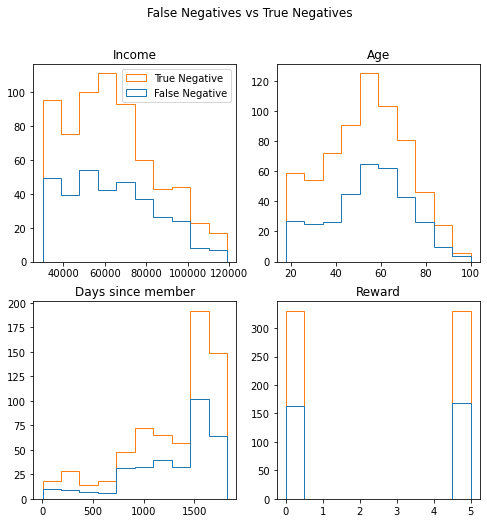

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].hist([fn_input.income, tn_input.income], histtype='step', label=["False Negative", "True Negative"])
ax[0, 0].set_title("Income")
ax[0, 0].legend()
ax[0, 1].hist([fn_input.age, tn_input.age], histtype='step')
ax[0, 1].set_title("Age")
ax[1, 0].hist([fn_input.days_since_member, tn_input.days_since_member], histtype='step')
ax[1, 0].set_title("Days since member")
ax[1, 1].hist([fn_input.reward, tn_input.reward], histtype='step')
ax[1, 1].set_title("Reward")
fig.suptitle('False Negatives vs True Negatives', fontsize=12)
plt.savefig("tn-vs-fn.png")

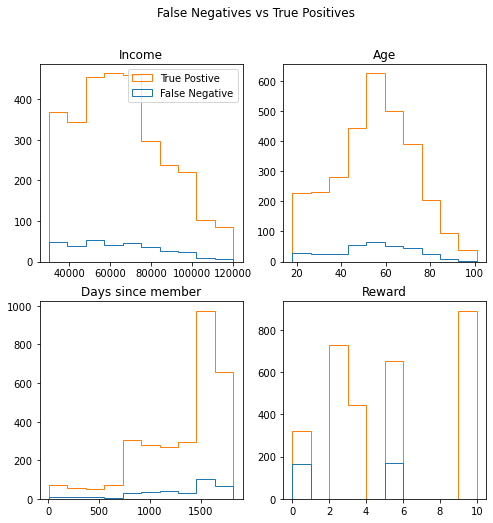

In [93]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].hist([fn_input.income, tp_input.income], histtype='step', label=["False Negative", "True Postive"])
ax[0, 0].set_title("Income")
ax[0, 0].legend()
ax[0, 1].hist([fn_input.age, tp_input.age], histtype='step')
ax[0, 1].set_title("Age")
ax[1, 0].hist([fn_input.days_since_member, tp_input.days_since_member], histtype='step')
ax[1, 0].set_title("Days since member")
ax[1, 1].hist([fn_input.reward, tp_input.reward], histtype='step')
ax[1, 1].set_title("Reward")
fig.suptitle('False Negatives vs True Positives', fontsize=12)
plt.savefig("images/fn-vs-tp.png")

In [94]:
delete_endpoint(best_predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2021-03-14-21-31-28-879
